# Ulysses Narrative GMM Turning Points

このノートブックは `scripts/run_report.py` と同等の処理を、Colabで実行する最小版である。


In [72]:
# ===== Cell 0: Setup (clone + install + import check) =====
import os, sys, shutil
from pathlib import Path

REPO_URL = "https://github.com/Mokafe/Mokafe-ulysses-narrative-gmm.git"
REPO_DIR = Path("/content/Mokafe-ulysses-narrative-gmm")

# 既存があれば削除してクリーンに（迷い防止）
if REPO_DIR.exists():
    shutil.rmtree(REPO_DIR)

%cd /content
!git clone {REPO_URL}
%cd {REPO_DIR}

# 依存（ログ見えるように -q なし）
!pip install -r requirements.txt

# src を import できるように
sys.path.insert(0, str(Path.cwd() / "src"))

import narrative_gmm
print("OK import narrative_gmm:", narrative_gmm.__file__)
print("CWD:", os.getcwd())
print("TOP:", sorted(os.listdir("."))[:20])


/content
Cloning into 'Mokafe-ulysses-narrative-gmm'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 42 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 723.30 KiB | 2.92 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/Mokafe-ulysses-narrative-gmm
OK import narrative_gmm: /content/Mokafe-ulysses-narrative-gmm/src/narrative_gmm/__init__.py
CWD: /content/Mokafe-ulysses-narrative-gmm
TOP: ['.git', 'LICENSE', 'README.md', 'data', 'docs', 'notebooks', 'pyproject.toml', 'requirements.txt', 'scripts', 'src']


In [73]:
# ===== Cell 1: Run build_report (generate outputs/) =====
from pathlib import Path
from narrative_gmm.report import build_report, ReportConfig

# 入力（repo内にある前提）
INPUT_PATH = "data/sample/ulysses_fixed.json"
assert Path(INPUT_PATH).exists(), f"missing input: {INPUT_PATH}"

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

cfg = ReportConfig(
    n_components=8,   # そのままでOK（軽くしたいなら 2 でもOK）
    seed=0,
    alpha=0.05,
    top_k=20,
    context_w=3,
    plots=True
)

paths = build_report(INPUT_PATH, str(OUT_DIR), cfg)
print("build_report done. returned paths:\n", paths)


build_report done. returned paths:
 {'events_all': PosixPath('outputs/events_all.csv'), 'preds_all': PosixPath('outputs/preds_all.csv'), 'boundary_topK': PosixPath('outputs/boundary_top20.csv'), 'boundary_context': PosixPath('outputs/boundary_context.csv'), 'scene_turning_density': PosixPath('outputs/scene_turning_density.csv'), 'scene_cluster_transitions': PosixPath('outputs/scene_cluster_transitions.csv'), 'gmm_params': PosixPath('outputs/gmm_params.npz')}


In [74]:
# ===== Cell 2: List outputs =====
from pathlib import Path

OUT_DIR = Path("outputs")
print("outputs exists:", OUT_DIR.exists())
print("outputs files:", sorted([p.name for p in OUT_DIR.glob("*")]))


outputs exists: True
outputs files: ['boundary_context.csv', 'boundary_top20.csv', 'events_all.csv', 'fig_cluster_timeline.png', 'fig_entropy_timeline.png', 'fig_turning_points.png', 'gmm_params.npz', 'preds_all.csv', 'scene_cluster_transitions.csv', 'scene_turning_density.csv']


In [77]:
# ===== Cell 3: Outputs sanity check =====
from pathlib import Path

OUT_DIR = Path("outputs")
assert (OUT_DIR/"preds_all.csv").exists(), "preds_all.csv がありません（build_report が完走していません）"
assert (OUT_DIR/"events_all.csv").exists(), "events_all.csv がありません（build_report が完走していません）"
print("OK: outputs ready -> このまま下の解析セル（転調点/検定/本文還元）へ進めます")


OK: outputs ready -> このまま下の解析セル（転調点/検定/本文還元）へ進めます


In [78]:
from pathlib import Path
import pandas as pd
import numpy as np

OUT_DIR = Path("outputs")
preds_path  = OUT_DIR / "preds_all.csv"
events_path = OUT_DIR / "events_all.csv"

assert preds_path.exists(), f"missing: {preds_path}（上の build_report を先に実行）"
assert events_path.exists(), f"missing: {events_path}（上の build_report を先に実行）"

preds  = pd.read_csv(preds_path)
events = pd.read_csv(events_path)

print("preds:", preds.shape, "events:", events.shape)


preds: (555, 18) events: (555, 14)


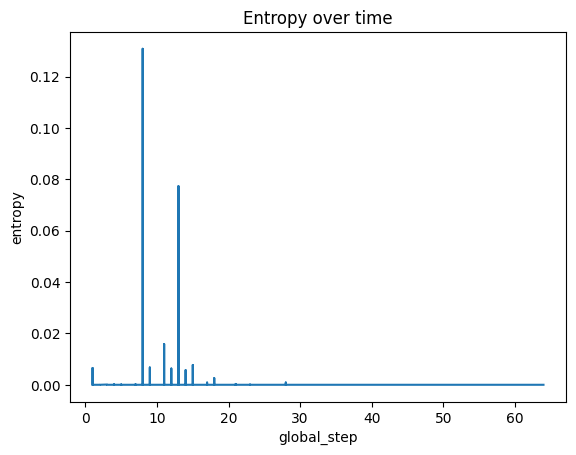

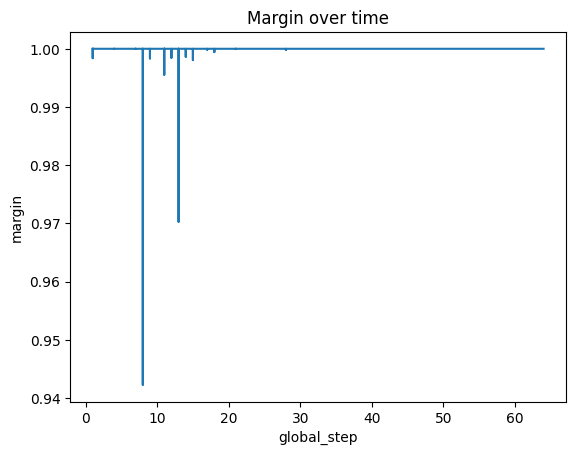

In [79]:
import matplotlib.pyplot as plt

time_col   = "global_step"
entropy_col= "entropy"
margin_col = "margin"

preds = preds.sort_values(time_col).reset_index(drop=True)

plt.figure()
plt.plot(preds[time_col], preds[entropy_col])
plt.title("Entropy over time")
plt.xlabel(time_col); plt.ylabel(entropy_col)
plt.show()

plt.figure()
plt.plot(preds[time_col], preds[margin_col])
plt.title("Margin over time")
plt.xlabel(time_col); plt.ylabel(margin_col)
plt.show()


In [80]:
# evidence列の自動検出（ja優先）
ev_col = None
for c in ["evidence_ja","evidence","evidence_en","quote","text"]:
    if c in events.columns:
        ev_col = c
        break
print("Detected evidence column:", ev_col)

K = 20
topK = preds.nlargest(K, entropy_col)[[time_col, entropy_col, margin_col]].copy()
merged = topK.merge(events, on=time_col, how="left")

cols = [time_col, entropy_col, margin_col] + ([ev_col] if ev_col else [])
display(merged[cols])


Detected evidence column: evidence_ja


,global_step,entropy,margin,evidence_ja
0,8,0.130792,0.942260,短文応答＋「gloomily」で情動主導。
1,8,0.130792,0.942260,命令形と質問で会話モードへ。
2,8,0.130792,0.942260,時間を越える言い回しで一般化が起きる。
3,8,0.130792,0.942260,移動語（went up / staircase / hall）で場面が切り替わる。
4,8,0.130792,0.942260,「law」から人名・授業描写（High school... teaching）へ移る。
...,...,...,...,...
348,12,0.000056,0.999992,メタ的な導入句で説明モードへ。
349,12,0.000056,0.999992,ラテン語引用で典礼的な言い回し。
350,12,0.000056,0.999992,距離の変化（close quarters）が明示。
351,12,0.000056,0.999992,呼気・火・配置の手順が具体化。


In [81]:
w = 3

events_sorted = events.sort_values(time_col).reset_index(drop=True)
idx_map = {int(t): i for i, t in enumerate(events_sorted[time_col].astype(int).tolist())}

def context_window(t, w=3):
    t = int(t)
    if t not in idx_map:
        return None
    i = idx_map[t]
    lo = max(0, i-w); hi = min(len(events_sorted), i+w+1)
    return events_sorted.iloc[lo:hi].copy()

top10 = preds.nlargest(10, entropy_col)[[time_col, entropy_col, margin_col]].copy()

for _, r in top10.iterrows():
    t = int(r[time_col])
    print("\n" + "="*80)
    print(f"{time_col}={t} | entropy={float(r[entropy_col]):.6g} | margin={float(r[margin_col]):.6g}")
    ctx = context_window(t, w=w)
    if ctx is None:
        print("context not found")
        continue
    show = [time_col] + ([ev_col] if ev_col else [])
    display(ctx[show])



global_step=8 | entropy=0.130792 | margin=0.94226


,global_step,evidence_ja
140,8,命令形と質問で会話モードへ。
141,8,時間を越える言い回しで一般化が起きる。
142,8,定型的な詩行で引用モード。
143,8,整形された反復句で、スクリプトが詩/歌へ切替。
144,9,第三者の動作描写が中心になる。
145,9,食べる動作と感覚語で知覚入力が優勢。
146,9,既知台詞の引用として出現。



global_step=13 | entropy=0.0773125 | margin=0.970272


,global_step,evidence_ja
230,13,行進描写で外界知覚へ。
231,13,形容語の連結で修辞密度が急増。
232,13,aching / void / heart があり emotion と physio を高めた。
233,13,「voice」で他者発話が想起され質問形になる。
234,14,断定的な短文で格言化。
235,14,ダッシュ付き発話で会話が明示される。
236,14,dressed / taste / Fashion により perception と goa...



global_step=11 | entropy=0.0158574 | margin=0.995535


,global_step,evidence_ja
194,11,命令形の社会的発話＋動作注記。
195,11,直接話法・業務的発話。
196,11,外部人物の出現・行為（figure / saluted）。
197,11,「symbol」「cracked lookingglass」で概念化/言語化。
198,12,忘れない・時刻などタスク列挙がある。
199,12,near/afar の反復でアンカーが揺れる。
200,12,「remember」「after my mother’s death」で回想アンカー。



global_step=15 | entropy=0.00769867 | margin=0.99806


,global_step,evidence_ja
266,15,「Reads」「Quickly」「practice」で観察→推測が同一流れ。
267,15,「took a page」「model farm」で紙面テキストへの移行。
268,15,打撃動作→歌唱の行為切替。
269,15,罵倒と命令形が連続し感情強度が上がる。
270,16,「front room」「paper」で場面が具体化。
271,16,reflect/reasoning が主で内的反すうへ移行。
272,16,反復（Watch!）と色・素材語で注意が点滅する。



global_step=9 | entropy=0.00672986 | margin=0.998337


,global_step,evidence_ja
158,9,直前の歌詞を続ける句。
159,9,視覚動詞（saw）と外観記述が中心。
160,9,身体感覚（concussed）と作業（match）が連結。
161,9,疑問文＋「Thumping」反復で作業音が思考に食い込む。
162,10,断片文が連なり、内言の流れが優位。
163,10,罵倒語が連続し、情動強度が上がる対話。
164,10,知覚動詞 perceived により視覚モードが前面化。



global_step=1 | entropy=0.00653156 | margin=0.998392


,global_step,evidence_ja
14,1,発話開始の導入句があり、会話へ切替。
15,1,舞台の場所語が中心で視覚的描写が主。
16,1,聴覚入力（ringing）中心の断片。
17,1,現在の場面を口語で立ち上げている。
18,2,呼称の反復と呼びかけ形式。
19,2,ダッシュと感嘆符で呼びかけの会話入力が明確。
20,2,外界対象（boy/offal）と命令調（Tell him）が同一スパンに並ぶ。



global_step=12 | entropy=0.00631733 | margin=0.998452


,global_step,evidence_ja
212,12,「Somewhere in the east」「Travel」で場所・行為が空想に移行。
213,12,受け取り（handed back）と応答（thanked）が連続。
214,12,メタ的な導入句で説明モードへ。
215,12,呼気・火・配置の手順が具体化。
216,13,引用符的再現（過去発話の再掲）。
217,13,“asked”で会話・質問マーカーが立つ。
218,13,指の探索（forefinger felt）と急な開封（ripping）が同居。



global_step=14 | entropy=0.00568896 | margin=0.998626


,global_step,evidence_ja
248,14,By の反復で移動・列挙。
249,14,ラテン語短句＋発話態度注記。
250,14,嗅覚語（fruitsmelling）と反復動作（lifting）。
251,14,韻律的な詩行で引用モードが優勢。
252,15,formed itself / floated out で連想離脱、場所がlibraryへ。
253,15,動作（strolled/picking）の連続。
254,15,ダッシュ＋発話動詞（said）で会話スイッチ。



global_step=18 | entropy=0.00258982 | margin=0.999435


,global_step,evidence_ja
320,18,文字操作（アナグラム）で音韻遊びが増す。
321,18,固有地名の連鎖で場所アンカー強化。
322,18,身体部位（nails）に視線が向き、観察→評価が生じる。
323,18,足元の砂・歩行の身体感覚が中心に戻る。
324,19,came forward / showing で知覚入力と対人状況が変化。
325,19,tantras 等の語彙で文体・参照密度が変化。
326,19,“says”と疑問形で対話モード。



global_step=28 | entropy=0.000878985 | margin=0.999831


,global_step,evidence_ja
481,28,予見語（foresaw）と身体描写（body reclined）が中心。
482,28,空間移動と光の語で環境アンカーが強く切替。
483,28,断片探索語からSafe!で完了感。
484,28,海上の遠景知覚＋短いラベルで切断。
485,29,会話（—）で一般命題に跳ぶ。
486,29,直後の出来事の評価＋身体語（stitch）。
487,29,未来（夜明け）への時間アンカー移動。


In [87]:
from scipy.stats import fisher_exact

def fisher_2x2_from_groups(df, group_col, flag_col):
    tab = pd.crosstab(df[group_col], df[flag_col])
    tab = tab.reindex(index=["top","random"], columns=[True, False], fill_value=0)
    a = int(tab.loc["top", True]);   b = int(tab.loc["top", False])
    c = int(tab.loc["random", True]);d = int(tab.loc["random", False])
    odds, p = fisher_exact([[a,b],[c,d]], alternative="two-sided")
    return tab, (a,b,c,d,odds,p)

K = 30
N = 30
seed = 0

tmp = preds[[time_col, entropy_col, margin_col]].dropna().copy()

top = tmp.nlargest(K, entropy_col).copy()
rest = tmp.drop(index=top.index)
rnd = rest.sample(n=min(N, len(rest)), random_state=seed).copy()

top["group_norm"] = "top"
rnd["group_norm"] = "random"
tv = pd.concat([top, rnd], axis=0).reset_index(drop=True)

thr = float(np.nanmedian(tv.loc[tv["group_norm"]=="random", margin_col]))
tv["ambiguous_by_margin"] = tv[margin_col] <= thr

tab, (a,b,c,d,odds,p) = fisher_2x2_from_groups(tv, "group_norm", "ambiguous_by_margin")

print(f"threshold: median_random thr={thr:.6f}")
print(tab)
print(f"Top ambiguous率: {a/max(a+b,1):.3f} ({a}/{a+b})")
print(f"Rnd ambiguous率: {c/max(c+d,1):.3f} ({c}/{c+d})")
print(f"Fisher two-sided p = {p:.6g} | odds ratio = {odds}")


threshold: median_random thr=1.000000
ambiguous_by_margin  True   False
group_norm                       
top                     30      0
random                  30      0
Top ambiguous率: 1.000 (30/30)
Rnd ambiguous率: 1.000 (30/30)
Fisher two-sided p = 1 | odds ratio = nan


In [88]:
merged_out = OUT_DIR / "turning_topK_with_evidence.csv"
merged[cols].to_csv(merged_out, index=False, encoding="utf-8-sig")
print("Saved:", merged_out)


Saved: outputs/turning_topK_with_evidence.csv


In [89]:
# ============================================================
# Post-check: margin 退化検出 + Fisher(Top vs Random) を安全に回す
#  - thr が max に貼り付く / ambiguous 全True になるケースを回避
#  - それでも退化なら「marginでは検定不能」と明示して止める
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import fisher_exact

OUT_DIR = Path("outputs")
preds_path = OUT_DIR / "preds_all.csv"
assert preds_path.exists(), f"missing: {preds_path}（build_report を先に実行）"

df = pd.read_csv(preds_path)

# ---- 必須列チェック（なければ確率列から再計算を試す）----
prob_cols = [c for c in df.columns if c.startswith(("p_", "prob_", "resp_"))]

if "margin" not in df.columns and prob_cols:
    P = df[prob_cols].to_numpy(float)
    order = np.argsort(-P, axis=1)
    p1 = P[np.arange(len(df)), order[:, 0]]
    p2 = P[np.arange(len(df)), order[:, 1]]
    df["margin"] = p1 - p2

if "entropy" not in df.columns and prob_cols:
    P = df[prob_cols].to_numpy(float)
    df["entropy"] = -(P * np.log(P + 1e-12)).sum(axis=1)

assert "entropy" in df.columns, f"entropy列がありません。columns={list(df.columns)[:50]}"
assert "margin"  in df.columns, f"margin列がありません。columns={list(df.columns)[:50]}"

# ---- Top vs Random の作り方（あなたの流儀）----
TOPN  = 30
RANDN = 30
SEED  = 0

df_sorted = df.sort_values("entropy", ascending=False).reset_index(drop=True)
top = df_sorted.head(TOPN).copy()
remain = df_sorted.iloc[TOPN:].copy()
rnd = remain.sample(n=RANDN, random_state=SEED).copy()

# ---- 退化チェック ----
def is_degenerate_margin(s: pd.Series, eps=1e-9) -> bool:
    s = s.dropna().astype(float)
    return (s.max() - s.min()) < eps

print("margin stats (top):")
print(top["margin"].describe())
print("\nmargin stats (rnd):")
print(rnd["margin"].describe())

if is_degenerate_margin(rnd["margin"], eps=1e-12):
    raise RuntimeError(
        "Random側のmarginが退化（ほぼ定数）しているため、"
        "margin-based Fisher は情報を持ちません。\n"
        "→ 対応: (1) margin定義を見直す (2) モデル設定/正則化を調整 "
        "(3) entropy主基準に切替"
    )

# ---- 閾値の安全化：thr が max に貼り付くなら 2番目の値へ落とす ----
def choose_thr(series: pd.Series, q=0.5) -> float:
    s = series.dropna().astype(float)
    thr = float(s.quantile(q))
    if np.isclose(thr, s.max()):
        uniq = np.unique(np.round(s.to_numpy(), 12))
        if len(uniq) >= 2:
            thr = float(uniq[-2])  # 2番目に大きい値
        else:
            thr = float(thr - 1e-6)
    return thr

thr = choose_thr(rnd["margin"], q=0.5)

both = pd.concat([top.assign(group="top"), rnd.assign(group="random")], ignore_index=True)

# ★ <= だと「thr=1.0貼り付き」で全True化しやすいので strict にする
both["ambiguous_by_margin"] = both["margin"] < thr

a = int(((both.group=="top")    & (both.ambiguous_by_margin)).sum())
b = int(((both.group=="top")    & (~both.ambiguous_by_margin)).sum())
c = int(((both.group=="random") & (both.ambiguous_by_margin)).sum())
d = int(((both.group=="random") & (~both.ambiguous_by_margin)).sum())

odds, p = fisher_exact([[a, b], [c, d]], alternative="two-sided")

print("\n=== Overall 2×2 (ambiguous_by_margin; robust) ===")
print(f"thr = {thr:.12f}  (derived from Random median with safeguard)")
print("Top   :", a, b)
print("Random:", c, d)
print(f"Top ambiguous率: {a/(a+b+1e-12):.3f} ({a}/{a+b})")
print(f"Rnd ambiguous率: {c/(c+d+1e-12):.3f} ({c}/{c+d})")
print(f"Fisher two-sided p = {p:.6g} | odds ratio = {odds}")


margin stats (top):
count    30.000000
mean      0.996623
std       0.011611
min       0.942260
25%       0.998829
50%       0.999983
75%       0.999998
max       0.999999
Name: margin, dtype: float64

margin stats (rnd):
count    3.000000e+01
mean     1.000000e+00
std      6.350824e-09
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: margin, dtype: float64

=== Overall 2×2 (ambiguous_by_margin; robust) ===
thr = 0.999999999999  (derived from Random median with safeguard)
Top   : 30 0
Random: 4 26
Top ambiguous率: 1.000 (30/30)
Rnd ambiguous率: 0.133 (4/30)
Fisher two-sided p = 7.84275e-13 | odds ratio = inf


In [90]:
import numpy as np
from scipy.stats import mannwhitneyu, ks_2samp

m_top = top["margin"].astype(float).to_numpy()
m_rnd = rnd["margin"].astype(float).to_numpy()

u = mannwhitneyu(m_top, m_rnd, alternative="less")   # top < rnd を検定
ks = ks_2samp(m_top, m_rnd, alternative="less")      # 累積分布が左に寄るか

print("Mann–Whitney U:", u)
print("KS test:", ks)
print("top mean/min:", float(m_top.mean()), float(m_top.min()))
print("rnd mean/min:", float(m_rnd.mean()), float(m_rnd.min()))


Mann–Whitney U: MannwhitneyuResult(statistic=np.float64(0.0), pvalue=np.float64(3.2394737924483704e-12))
KS test: KstestResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), statistic_location=np.float64(1.0), statistic_sign=np.int8(-1))
top mean/min: 0.9966233668677054 0.9422600126184284
rnd mean/min: 0.9999999987137381 0.9999999652952394


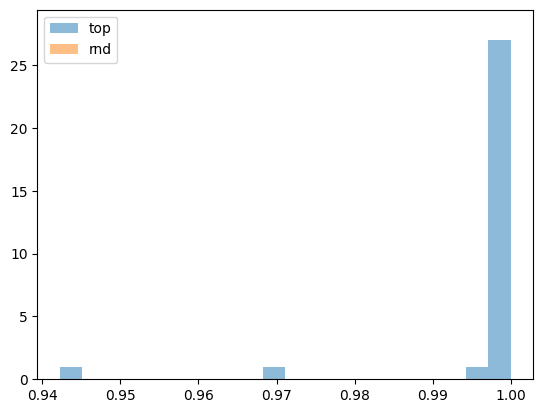

top n=30, rnd n=30
top median/std: 0.999982747542707, 0.011415390166456492
rnd median/std: 1.0, 6.244080085492985e-09


In [91]:
# 分布の可視化
import matplotlib.pyplot as plt
plt.hist(m_top, alpha=0.5, label='top', bins=20)
plt.hist(m_rnd, alpha=0.5, label='rnd', bins=20)
plt.legend()
plt.show()

# サンプルサイズの確認
print(f"top n={len(m_top)}, rnd n={len(m_rnd)}")

# 中央値や分散も確認
print(f"top median/std: {np.median(m_top)}, {np.std(m_top)}")
print(f"rnd median/std: {np.median(m_rnd)}, {np.std(m_rnd)}")

In [92]:
from scipy.stats import ks_2samp
print("KS (top smaller than rnd) => use alternative='greater'")
print(ks_2samp(m_top, m_rnd, alternative="greater"))


KS (top smaller than rnd) => use alternative='greater'
KstestResult(statistic=np.float64(1.0), pvalue=np.float64(8.455616946072366e-18), statistic_location=np.float64(0.9999993659253608), statistic_sign=np.int8(1))


In [93]:
import numpy as np

def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    # delta = P(x>y) - P(x<y)
    gt = (x[:,None] > y[None,:]).mean()
    lt = (x[:,None] < y[None,:]).mean()
    return float(gt - lt)

print("Cliff's delta (margin, top vs rnd):", cliffs_delta(m_top, m_rnd))
print("Top median:", float(np.median(m_top)), "Rnd median:", float(np.median(m_rnd)))


Cliff's delta (margin, top vs rnd): -1.0
Top median: 0.999982747542707 Rnd median: 1.0


In [101]:
from pathlib import Path
import pandas as pd

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR/"preds_all.csv")
events = pd.read_csv(OUT_DIR/"events_all.csv")

# --- 1) merge_keys を自動決定 ---
merge_keys = None
key_candidates = [
    ["global_step"],                 # 最優先（時系列で一意になりやすい）
    ["doc_id", "global_step"],
    ["chapter", "span_id"],
    ["doc_id", "span_id"],
    ["span_id"],                     # 最後の手段
]

for keys in key_candidates:
    if all(k in preds.columns for k in keys) and all(k in events.columns for k in keys):
        merge_keys = keys
        break

if merge_keys is None:
    raise ValueError(
        "preds/events で共通キーが見つかりません。\n"
        f"preds cols head: {list(preds.columns)[:30]}\n"
        f"events cols head: {list(events.columns)[:30]}"
    )

print("merge_keys =", merge_keys)

# --- 2) _x/_y を避けるため preds 側の本文系列を落とす ---
drop_like = [c for c in preds.columns if c.startswith(("evidence", "span_text", "transition_type"))]
preds2 = preds.drop(columns=drop_like, errors="ignore")

# --- 3) merge（重複で増えないように軽く重複除去） ---
preds2  = preds2.drop_duplicates(subset=merge_keys, keep="first")
events2 = events.drop_duplicates(subset=merge_keys, keep="first")

df = preds2.merge(events2, on=merge_keys, how="left")

print("df columns head:", list(df.columns)[:30])
print("df rows:", len(df))


merge_keys = ['global_step']
df columns head: ['doc_id_x', 'work_x', 'episode_x', 'global_step', 'time_anchor_x', 'place_anchor_x', 'anchor_strength_x', 'status_x', 'label_x', 'cluster', 'p_max', 'entropy', 'margin', 'doc_id_y', 'work_y', 'episode_y', 'span_text_en', 'span_text_ja', 'evidence_en', 'evidence_ja', 'transition_type', 'time_anchor_y', 'place_anchor_y', 'anchor_strength_y', 'status_y', 'label_y']
df rows: 64


In [102]:
# Top entropy 抽出
evidence_col = None
for c in ["evidence_ja","evidence_en","evidence","quote","text","raw_text"]:
    if c in df.columns:
        evidence_col = c
        break

assert "entropy" in df.columns and "margin" in df.columns
assert evidence_col is not None, "evidence列が見つかりません（events_all.csv 側の列を確認してください）"

TOPN = 30
top = df.sort_values("entropy", ascending=False).head(TOPN).copy()

show_cols = [c for c in (merge_keys + ["entropy","margin","transition_type", evidence_col]) if c in top.columns]
top_out = top[show_cols].copy()

display(top_out)
top_out.to_csv(OUT_DIR/"top_entropy_points_with_evidence.csv", index=False, encoding="utf-8-sig")
print("Saved:", OUT_DIR/"top_entropy_points_with_evidence.csv")


,global_step,entropy,margin,transition_type,evidence_ja
13,14,5.688961e-03,0.998626,completion,焦点語「offence」「me」で自己へ収束。
46,47,1.154524e-05,0.999998,script_switch,歌唱形式の反復句。
53,54,6.844834e-06,0.999999,self_censor,自己正当化の弁明句。
51,52,2.933224e-06,1.000000,intrusion,短語反復で合唱的。
32,33,8.291217e-07,1.000000,rumination,警告・一般化（dodge）で推論寄り。
38,39,3.165728e-07,1.000000,intrusion,名指しの呼びかけで侵入的。
3,4,1.193538e-07,1.000000,contrast,「sleepy」等の生理・感情語で内的状態。
23,24,8.080339e-08,1.000000,contrast,「free thought」など抽象語で推論・言語主導。
12,13,6.211492e-08,1.000000,intrusion,引用符的再現（過去発話の再掲）。
10,11,1.674665e-08,1.000000,semantic_association,「symbol」「cracked lookingglass」で概念化/言語化。


Saved: outputs/top_entropy_points_with_evidence.csv


In [103]:
# ===== Add-on (1 cell): transition_type enrichment (Top vs Random / Fisher) =====
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import fisher_exact

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR/"preds_all.csv")
events = pd.read_csv(OUT_DIR/"events_all.csv")

# ---- merge_keys auto ----
merge_keys = None
key_candidates = [
    ["global_step"],
    ["doc_id", "global_step"],
    ["chapter", "span_id"],
    ["doc_id", "span_id"],
    ["span_id"],
]
for keys in key_candidates:
    if all(k in preds.columns for k in keys) and all(k in events.columns for k in keys):
        merge_keys = keys
        break
if merge_keys is None:
    raise ValueError(
        "No common merge keys found.\n"
        f"preds head cols={list(preds.columns)[:30]}\n"
        f"events head cols={list(events.columns)[:30]}"
    )
print("merge_keys =", merge_keys)

# ---- avoid _x/_y: drop text/evidence-like columns from preds ----
drop_like = [c for c in preds.columns if c.startswith(("evidence", "span_text", "transition_type"))]
preds2  = preds.drop(columns=drop_like, errors="ignore").drop_duplicates(subset=merge_keys, keep="first")
events2 = events.drop_duplicates(subset=merge_keys, keep="first")

df = preds2.merge(events2, on=merge_keys, how="left")

# ---- required cols ----
assert "entropy" in df.columns, f"entropy missing. cols={list(df.columns)[:40]}"
assert "margin"  in df.columns, f"margin missing. cols={list(df.columns)[:40]}"
assert "transition_type" in df.columns, f"transition_type missing. cols={list(df.columns)[:40]}"

# ---- parameters (edit if you want) ----
TOPN  = 30
RANDN = 30
SEED  = 0

# ---- build Top vs Random ----
df_sorted = df.sort_values("entropy", ascending=False).reset_index(drop=True)
top = df_sorted.head(TOPN).copy()

remain = df_sorted.iloc[TOPN:].copy()
if len(remain) < RANDN:
    raise ValueError(f"Not enough remaining rows for RANDN={RANDN}. remain={len(remain)}")

rnd = remain.sample(n=RANDN, random_state=SEED).copy()

top["group"] = "top"
rnd["group"] = "random"
both = pd.concat([top, rnd], ignore_index=True)

# ---- transition_type enrichment (2×2 per type) ----
types = sorted(both["transition_type"].fillna("NA").astype(str).unique().tolist())

rows = []
for t in types:
    top_has = int((top["transition_type"].fillna("NA").astype(str) == t).sum())
    rnd_has = int((rnd["transition_type"].fillna("NA").astype(str) == t).sum())
    top_no  = int(len(top) - top_has)
    rnd_no  = int(len(rnd) - rnd_has)

    odds, p = fisher_exact([[top_has, top_no], [rnd_has, rnd_no]], alternative="two-sided")
    rows.append({
        "transition_type": t,
        "top_count": top_has,
        "rnd_count": rnd_has,
        "top_rate": top_has / len(top),
        "rnd_rate": rnd_has / len(rnd),
        "diff_rate_top_minus_rnd": (top_has / len(top)) - (rnd_has / len(rnd)),
        "odds_ratio": (float(odds) if np.isfinite(odds) else np.inf),
        "p_fisher_two_sided": float(p),
    })

enr = pd.DataFrame(rows).sort_values(
    ["p_fisher_two_sided", "diff_rate_top_minus_rnd"],
    ascending=[True, False]
).reset_index(drop=True)

print("\n=== transition_type enrichment (Top vs Random; Fisher 2×2 per type) ===")
display(enr)

out_csv = OUT_DIR / "transition_type_enrichment_fisher_top_vs_random.csv"
enr.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("\nSaved:", out_csv)

# ---- also save the sampled sets for reproducibility ----
keep_cols = [c for c in (merge_keys + ["entropy","margin","transition_type"]) if c in both.columns]
both_out = both[keep_cols + ["group"]].copy()
both_out.to_csv(OUT_DIR/"top_vs_random_sample_for_enrichment.csv", index=False, encoding="utf-8-sig")
print("Saved:", OUT_DIR/"top_vs_random_sample_for_enrichment.csv")


merge_keys = ['global_step']

=== transition_type enrichment (Top vs Random; Fisher 2×2 per type) ===


,transition_type,top_count,rnd_count,top_rate,rnd_rate,diff_rate_top_minus_rnd,odds_ratio,p_fisher_two_sided
0,contrast,4,1,0.133333,0.033333,0.100000,4.461538,0.353256
1,completion,2,4,0.066667,0.133333,-0.066667,0.464286,0.670749
2,script_switch,7,9,0.233333,0.300000,-0.066667,0.710145,0.771024
3,self_censor,1,0,0.033333,0.000000,0.033333,inf,1.000000
4,intrusion,10,9,0.333333,0.300000,0.033333,1.166667,1.000000
5,semantic_association,3,3,0.100000,0.100000,0.000000,1.000000,1.000000
6,rumination,3,4,0.100000,0.133333,-0.033333,0.722222,1.000000



Saved: outputs/transition_type_enrichment_fisher_top_vs_random.csv
Saved: outputs/top_vs_random_sample_for_enrichment.csv
